# Exploratory Data Analysis

We see 9 different files, each with numerous transactions along with other metadata.

Let us drill down and see what we can find. 

In [1]:
import pandas as pd
import glob

import matplotlib.pyplot as plt


import seaborn as sns

import datetime
import numpy as np

Importing files

In [2]:
files = glob.glob("data/*.csv")

In [3]:
columns = ['sku', 'brand', 'cat', 'bill', 'store', 'date', 'type', 'mrp', 'price', 'qty']

The 'source' column below is a marker to indicate file origin of the observation 

In [4]:
#Helper function to read multiple csv files and store it in a dictionary. Found in helper.py

from helper import read_files

In [5]:
df_dict = read_files(files, columns)

#    

##### Question 1 - The data is split into 9 files. Does it mean anything? 

In [6]:
#Helper function to test for overlap in the different files. Found in helper.py

from helper import overlap

In [7]:
#A few random checks for overlaps

overlap(df_dict['df1'], df_dict['df2'], 'sku')

'Overlaps found for sku'

In [8]:
overlap(df_dict['df1'], df_dict['df6'], 'brand')

'Overlaps found for brand'

In [9]:
overlap(df_dict['df4'], df_dict['df7'], 'bill')

'There is no overlap'

##### Answer-  It appears that the transactions are put into different files on the basis of different bill numbers

We assume that other than this, there is not much difference between the transactions in the files.

Hence, we are going to concatenate all the 9 files into one big file. 

In [10]:
df = pd.concat(df for df in df_dict.values())

#     

### Data cleaning and formatting

We keep store number only instead of the string

In [11]:
df['store'] = df['store'].apply(lambda x: x[-1])

###### Handling duplicate values

In [12]:
num_duplicated = df.duplicated(keep='first').sum()

print("There are {} duplicate rows".format(num_duplicated))

There are 3889 duplicate rows


We drop the duplicate rows on second occurrence 

In [13]:
df = df.drop_duplicates(keep="first")

###### Handling missing values

In [14]:
df.isna().sum()

sku        0
brand     11
cat        9
bill       0
store      0
date       0
type       0
mrp        0
price      0
qty        0
source     0
dtype: int64

###### Only brand and cat columns have missing values. Let's investigate further. 

In [15]:
# Subset where brand is NaN

df[df['brand'].isnull()]

,sku,brand,cat,bill,store,date,type,mrp,price,qty,source
10,SKU0726,NaN,Cat01,BILL02585,6,2017-07-19,Sale,54.67,54.67,1,9
29,SKU2585,NaN,NaN,BILL09133,3,2017-09-09,Sale,2.60,2.60,1,4
1278,SKU2649,NaN,NaN,BILL09643,3,2017-09-06,Sale,8.00,8.00,1,4
1372,SKU2653,NaN,NaN,BILL09736,3,2017-09-07,Sale,30.00,30.00,1,4
1373,SKU2649,NaN,NaN,BILL09737,3,2017-09-07,Sale,8.00,8.00,1,4
1434,SKU2654,NaN,NaN,BILL09771,3,2017-09-07,Sale,9.67,9.67,1,4
1478,SKU2657,NaN,NaN,BILL09798,3,2017-09-08,Sale,3.73,0.00,1,4
1482,SKU2658,NaN,NaN,BILL09802,3,2017-09-08,Sale,4.33,4.33,1,4
1490,SKU2659,NaN,NaN,BILL09809,3,2017-09-08,Sale,4.33,4.33,1,4
1506,SKU2661,NaN,NaN,BILL09825,3,2017-09-08,Sale,3.99,3.99,1,4


###### Instead of throwing the data away, we replace missing brands by 'UnkBRAND' and missing categories by 'UnkCAT'

In [16]:
df.loc[df['brand'].isnull(), 'brand'] = 'UnkBRAND'

df.loc[df['cat'].isnull(), 'cat'] = 'UnkCAT'

In [17]:
### Extracting day, month, dayofweek and weekend flag from date

In [18]:
df['date'] = pd.to_datetime(df['date'])

df['day'] = pd.DatetimeIndex(df['date']).day

df['month'] = pd.DatetimeIndex(df['date']).month_name()

df['dayofweek'] = pd.DatetimeIndex(df['date']).day_name()

weekend_days = ['Saturday', 'Sunday']

df['weekend'] = np.where(df['dayofweek'].isin(weekend_days), 1, 0)

###### Creating total price, discount and percentage discount features

In [19]:
df['total'] = df['price'] * df['qty']

df['discount'] = df['mrp'] - df['price']

df['perc_discount'] = ((df['mrp'] - df['price']) / df['mrp']) * 100

#      

### We visualise columns by transaction count 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

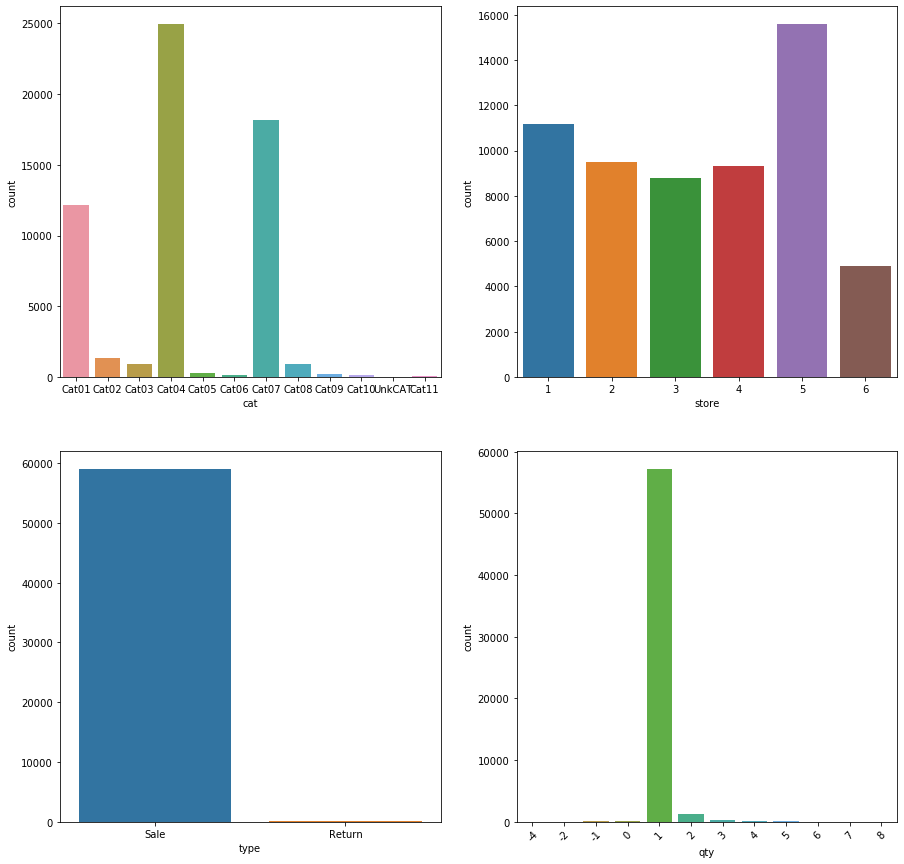

In [20]:
fig, axs = plt.subplots(2, 2, figsize = (15,15))

cat_plot = sns.countplot(df['cat'], ax=axs[0,0])

plt.xticks(rotation=45)


store_plot = sns.countplot(df['store'], ax=axs[0,1])
plt.xticks(rotation=45)

sale_type_plot = sns.countplot(df['type'], ax=axs[1,0])
plt.xticks(rotation=45)
    
qty_plot = sns.countplot(df['qty'], ax=axs[1,1])
plt.xticks(rotation=45)


SKUs of Category 4 are highest-selling by volume. Store 5 has the most number of transactions. 

Most SKUs are sold in singular quantities. The vast majority of transactions are sales.  

#    

###### Question - Notice that there are transactions with zero quantity. Examining the dataset confirms this. 
###### What do we do here? 

In [21]:
zero_qty = df[df['qty'] == 0]

zero_qty.head()

,sku,brand,cat,bill,store,date,type,mrp,price,qty,source,day,month,dayofweek,weekend,total,discount,perc_discount
10122,SKU0651,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,0.0,0.0,0.0
10123,SKU0663,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,0.0,0.0,0.0
10124,SKU0630,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,0.0,0.0,0.0
10125,SKU0635,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,0.0,0.0,0.0
10126,SKU0634,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,0.0,0.0,0.0


###### Answer - Zero quantity transactions don't make sense. Also, their MRP and price are equal (at 1.33), even though they are different SKUs. This suggests it is probably noise. So we remove these transactions. 

In [22]:
df = df[df['qty'] != 0]

#     

###### Question - Is there anything peculiar about the SKUs that are recorded as sold at zero quantity? 

In [23]:
zero_qty_skus = zero_qty.sku.unique()

zero_qty_skus

array(['SKU0651', 'SKU0663', 'SKU0630', 'SKU0635', 'SKU0634', 'SKU0627',
       'SKU0638', 'SKU0632', 'SKU0667', 'SKU0637', 'SKU0653', 'SKU0633',
       'SKU0639', 'SKU0642', 'SKU0641', 'SKU0636', 'SKU0650', 'SKU0654',
       'SKU0648', 'SKU2134'], dtype=object)

In [24]:
for sku in zero_qty_skus:
    print("Price: ", set(df[df['sku'] == sku]['price']),
         "Qty: ", set(df[df['sku'] == sku]['qty']))

Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, -2, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -2, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}


###### Answer - All of them are priced at either 0 or 1.33, and the quantity fluctuates. 

###### For further investigation we need more information about the SKUs from the source, but since this is an anonymous dataset, this is not possible. 

###### Hence, even though they appear to be noise (at a cursory glance), we retain these transactions for now.

#  

We see if there is overcharging (where price is greater than MRP)

In [25]:
overcharged = df[df['price'] > df['mrp'] ]

print(overcharged.shape[0])

overcharged[['mrp', 'price']].tail()

1665


,mrp,price
11420,20.00,22.00
11428,22.00,24.00
11431,55.33,60.00
11432,88.00,96.00
11496,88.67,96.67


Overcharging does happen on 1665 transactions. Some of these SKUs have MRP = 0.

One possible explanation for this is that these SKUs were intended to be discounted, but were sold at a higher price, mistakenly or otherwise.

For the sake of simplicity, we 'rectify' this issue by forcing the MRP to match the price (since price is what the customer has already paid). 

###### We assume the MRP was entered wrongly and so the discount is zero. Not recommended in an actual setting.  

In [26]:
df['mrp'] = np.where(df.price > df.mrp, df.price, df.mrp)

#   

###### Some of the SKUs have MRP.= 0. We investigate it. 

In [27]:
zero_mrp = df[df['mrp'] == 0]

zero_mrp_skus = zero_mrp.sku.unique().tolist() 

In [28]:
print("{} transactions have zero MRP, which is recorded under {} different SKUs.".format(zero_mrp.shape[0], len(zero_mrp_skus)))

699 transactions have zero MRP, which is recorded under 123 different SKUs.


###### Question - Are these SKUs always sold for MRP = 0 every time?    

In [29]:
zero_mrp_skus_avg_mrps = df[(df['sku'].isin(zero_mrp_skus)) & (df['mrp'] != 0)].groupby('sku')['mrp'].agg(lambda x : np.mean(x))

zero_mrp_skus_avg_mrps

sku
SKU3676    0.01
Name: mrp, dtype: float64

###### Just one transaction with an MRP of 0.01. This is almost certainly an anomaly. 

###### So we can discard all MRPs that are 0. 

In [32]:
df =  df[df['mrp'] != 0]

sku              0
brand            0
cat              0
bill             0
store            0
date             0
type             0
mrp              0
price            0
qty              0
source           0
day              0
month            0
dayofweek        0
weekend          0
total            0
discount         0
perc_discount    0
dtype: int64

In [30]:
print("Complete run")

Complete run
